In [1]:
# load dataset data/test.csv and data/train.csv

import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)

train.head()

(120000, 2) (7600, 2)


,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar alltime record posing new menac...,2


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TF-IDF vectorizer object for english
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# fit the object with the training data
tfidf.fit(train.text)

# transform the training data
train_tfidf = tfidf.transform(train.text)

# transform the test data
test_tfidf = tfidf.transform(test.text)

print(train_tfidf.shape, test_tfidf.shape)

(120000, 41066) (7600, 41066)


In [5]:
from sklearn.decomposition import TruncatedSVD

# Number of topics
n_topics = 4

# Apply NMF for topic modeling on the vectorized data
lsa = TruncatedSVD(n_components=n_topics, random_state=42).fit(train_tfidf)

# transform the training data
train_lsa = lsa.transform(train_tfidf)

# transform the test data
test_lsa = lsa.transform(test_tfidf)

print(train_lsa.shape, test_lsa.shape)

(120000, 4) (7600, 4)


In [6]:
import numpy as np

# Get the dominant topic for each 
dominant_topics = np.argmax(train_lsa, axis=1)

# distribution of dominant topics
import pandas as pd
pd.Series(dominant_topics).value_counts()

0    95268
3    14702
2     6802
1     3228
Name: count, dtype: int64

In [7]:
# print the top 15 words for each topic
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(lsa.components_):
    print(f"Topic #{topic_idx}:")
    # print the top words with their probabilities
    for i in topic.argsort()[:-15 - 1:-1]:
        print(f"{feature_names[i]}: {topic[i]}")
    print()

Topic #0:
reuters: 0.22923417260126464
new: 0.2154140407976959
oil: 0.2035587286865002
said: 0.18762801932829523
ap: 0.18673044090671187
price: 0.16267927478121466
stock: 0.13553472587784363
year: 0.12106121864481512
company: 0.11762293451513608
york: 0.11102527184348748
iraq: 0.09657448835417949
world: 0.0964414190940429
wednesday: 0.09113381628156116
monday: 0.09094694073500136
tuesday: 0.09092887774120284

Topic #1:
oil: 0.4892497319588522
price: 0.3561699806270415
stock: 0.24726462532603816
crude: 0.1398950478567995
barrel: 0.11076261340837953
higher: 0.0953887726096292
reuters: 0.08974386222332578
high: 0.08911791557491601
profit: 0.0849206027201185
supply: 0.08388900176056767
york: 0.08074857119840684
dollar: 0.07126513728708093
percent: 0.06898229866607089
rise: 0.06617225273180277
investor: 0.06520288871797279

Topic #2:
oil: 0.2550296332961078
iraq: 0.25180949666732716
killed: 0.1422707264528945
baghdad: 0.13854835260486228
iraqi: 0.13790045832384382
price: 0.13398357898655366

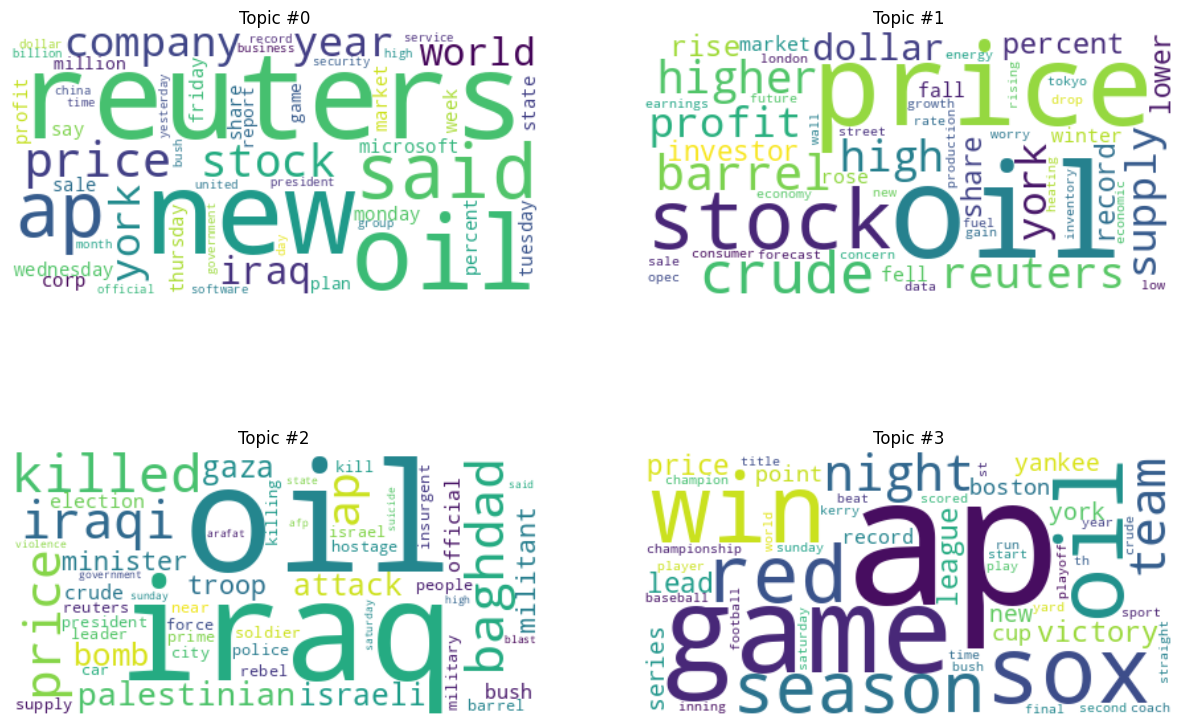

In [8]:
# use wordclouds to visualize each topic
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Creating a word cloud for each topic
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# no need to visualize the top 15, just visualize ALL the words
for topic_idx, topic in enumerate(lsa.components_):
    # create a dataframe with words and their probabilities
    df = pd.DataFrame([feature_names, topic]).T
    df.columns = ['words', 'probabilities']
    # create a dictionary with words and their probabilities
    words = dict(zip(df.words, df.probabilities))
    # create the wordcloud
    wc = WordCloud(background_color='white', max_words=50)
    wc.generate_from_frequencies(words)
    # plot the wordcloud
    axs[topic_idx].imshow(wc, interpolation='bilinear')
    axs[topic_idx].set_title(f'Topic #{topic_idx}')
    axs[topic_idx].axis('off')
    
plt.show()

In [12]:
import pandas as pd

n_labels = 4

# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(train)):
    topic = dominant_topics[i]
    label = train.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

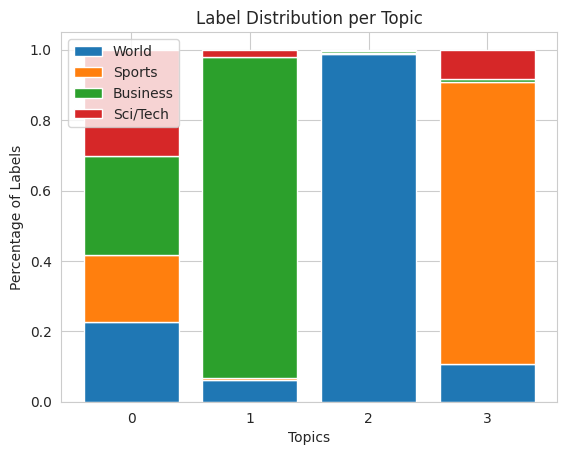

In [13]:
import matplotlib.pyplot as plt
import numpy as np

label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = train.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()

In [15]:
# let's do the same thing for the test data
# Get the dominant topic for each 
dominant_topics = np.argmax(test_lsa, axis=1)

pd.Series(dominant_topics).value_counts()

0    6048
3     958
2     416
1     178
Name: count, dtype: int64

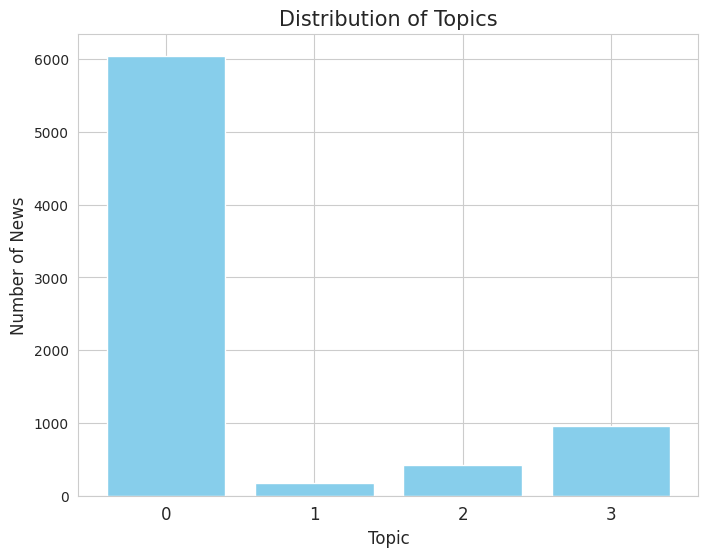

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Count the number of news items per topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

# Set a style (optional)
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 6))  # Adjust size as needed
plt.bar(topic_counts.index, topic_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of News', fontsize=12)
plt.xticks(topic_counts.index, fontsize=12)
plt.title('Distribution of Topics', fontsize=15)

# Show plot
plt.show()

/tmp/ipykernel_3726392/848308501.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_labels)  # You can choose other colormaps like 'Set2', 'viridis', etc.


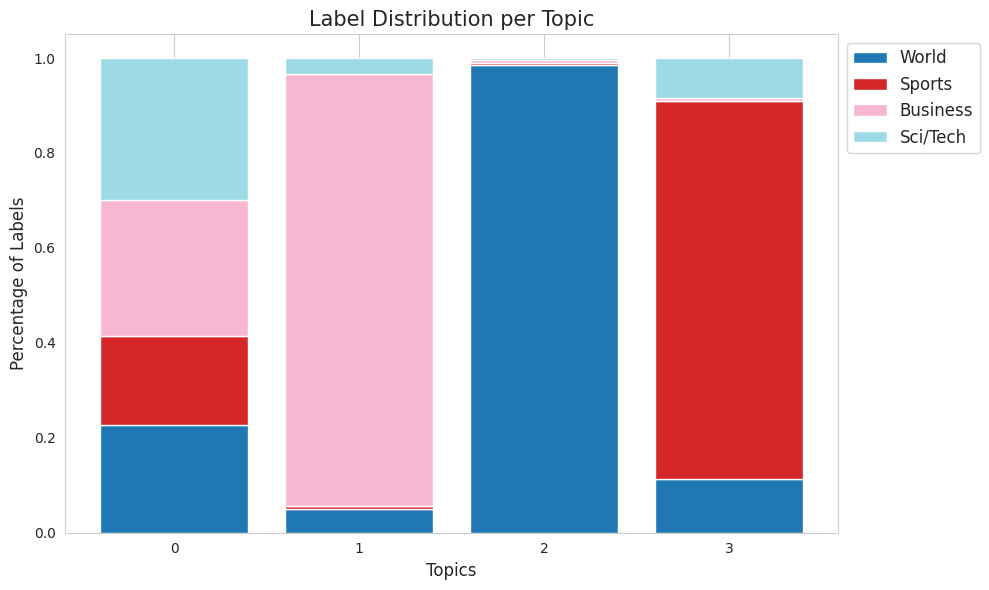

In [17]:
# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(test)):
    topic = dominant_topics[i]
    label = test.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = test.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Select a color palette
colors = plt.cm.get_cmap('tab20', n_labels)  # You can choose other colormaps like 'Set2', 'viridis', etc.

for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, color=colors(label), label=label_names[label])

ax.set_xlabel('Topics', fontsize=12)
ax.set_ylabel('Percentage of Labels', fontsize=12)
ax.set_title('Label Distribution per Topic', fontsize=15)
ax.set_xticks(range(n_topics))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
ax.grid(axis='y')  # Add horizontal gridlines

plt.tight_layout()  # Adjust layout to fit everything
plt.show()